In [7]:
# %pip install fast_pagerank

In [8]:
import numpy as np
import pandas as pd
import networkx as nx
from fast_pagerank import pagerank_power

In [21]:
g = nx.gnc_graph(n=100)

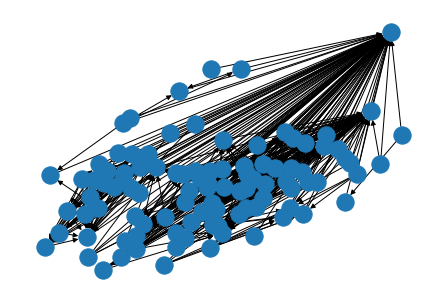

In [22]:
nx.draw(g)

In [28]:
np.array(list(nx.average_neighbor_degree(g).values())).mean()

1.63

In [34]:
g.number_of_edges()

425

In [35]:
sparse_am = nx.adjacency_matrix(g)

In [45]:
sparse_am_array = sparse_am.toarray()

In [51]:
ls = [n for n in g.nodes()]

In [69]:
def get_circle_of_trust(network, sparse_adj, node_id, k_for_circle_of_trust=20, cot_factor= 0.05, tol=1e-8,
                damping_factor=.85, k_for_recommendation=-1):
    
    # k_for_circle_of_trust = int(network.number_of_nodes()*cot_factor)
    #1st phase: Compute circle of trust of user according to Personalized PageRank
    personalize = np.zeros(shape=network.number_of_nodes())
    personalize[node_id] = 1
    values_of_personalized_pr = pagerank_power(sparse_adj, p=damping_factor, personalize=personalize, tol=1e-6)
    circle_of_trust = values_of_personalized_pr.argsort()[-k_for_circle_of_trust:][::-1]

    return circle_of_trust

In [70]:
cot = get_circle_of_trust(g, sparse_am, 2, k_for_circle_of_trust=5, cot_factor=0.05, )

In [68]:
cot

array([ 2,  0,  1, 37, 27], dtype=int64)

In [73]:
g.in_edges(2)

InEdgeDataView([(4, 2), (10, 2), (12, 2), (15, 2), (17, 2), (24, 2), (26, 2), (27, 2), (38, 2), (44, 2), (47, 2), (48, 2), (50, 2), (53, 2), (54, 2), (58, 2), (69, 2), (71, 2), (74, 2), (75, 2), (79, 2), (80, 2), (82, 2), (87, 2), (95, 2), (97, 2)])

In [ ]:
def twitter_wtf(network, sparse_adj, node_id, k_for_circle_of_trust=20, cot_factor= 0.05, tol=1e-8,
                damping_factor=.85, k_for_recommendation=-1):
    """This method aims to realize a link prediction algorithm used by Twitter to perform
        the WTF recommendation on the platform.
        The algorithm can be seen at 'https://web.stanford.edu/~rezab/papers/wtf_overview.pdf'.
        The algorithm consists of two phases:
            1) Compute the circle of trust for the user you want to recommend(top-k nodes in PPR)
            2) Compute the top-k nodes using score propagation
    """
    k_for_circle_of_trust = int(network.number_of_nodes()*cot_factor)
    #1st phase: Compute circle of trust of user according to Personalized PageRank
    personalize = np.zeros(shape=network.number_of_nodes())
    personalize[node_id] = 1
    values_of_personalized_pr = pagerank_power(sparse_adj, p=damping_factor, personalize=personalize, tol=1e-6)
    circle_of_trust = values_of_personalized_pr.argsort()[-k_for_circle_of_trust:][::-1]

    #2nd phase: init bipartite graph
    bipartite_graph = nx.DiGraph()
    #add nodes belonging to the circle of trust as hubs(H)
    for node in circle_of_trust:
        #these nodes are "hubs"(H) in the bipartite graph
        bipartite_graph.add_node(str(node)+"H")
    #add out neighbors of nodes belonging to the circle of trust as authorities(A)
    for node in circle_of_trust:
        for out_neighbor in network.neighbors(node):
            #direction is inverted for a matter of simplicity in the sequent phases
            bipartite_graph.add_edge(str(out_neighbor)+"A", str(node)+"H")

    #retrieve adjacency matrix of bipartite graph
    A = nx.to_numpy_array(bipartite_graph)

    #retrieve list of all nodes splitted by authority or hub
    all_nodes = list(bipartite_graph.nodes())
    hub_nodes = [int(x[:-1]) for x in all_nodes if 'H' in x]
    authority_nodes = [int(x[:-1]) for x in all_nodes if 'A' in x]

    #3rd phase: start building ingredients of our SALSA algorithm
    #these are the transition matrices determined by the bipartite graph
    S_prime = A[len(hub_nodes):, :][:, :len(hub_nodes)].copy()
    R_prime = S_prime.T.copy()
    #normalize both matrices
    denominator_S_prime = S_prime.sum(axis=0)
    denominator_S_prime[denominator_S_prime == 0] = 1
    S_prime = S_prime / denominator_S_prime
    denominator_R_prime = R_prime.sum(axis=0)
    denominator_R_prime[denominator_R_prime == 0] = 1
    R_prime = R_prime / denominator_R_prime
    #these are the vectors which contain the score of similarity
    #and relevance
    s = np.zeros(shape=(len(hub_nodes), 1), dtype=np.float)
    r = np.zeros(shape=(len(authority_nodes), 1), dtype=np.float)

    #at the beginning of the procedure we put the similarity
    #of the user we want to give the recommendation equal to 1
    index_of_node_to_recommend = np.where(circle_of_trust == node_id)[0][0]
    s[index_of_node_to_recommend] = 1.

    #init damping vector
    alpha = 1 - damping_factor
    alpha_vector = np.zeros(shape=(len(hub_nodes), 1), dtype=np.float)
    alpha_vector[index_of_node_to_recommend] = alpha

    #4th phase: run the algorithm
    convergence = False
    while not convergence:
        s_ = s.copy()
        r_ = r.copy()
        r_ = S_prime.dot(s)
        s_ = alpha_vector + (1 - alpha)*(R_prime.dot(r))
        #compute difference and check if convergence has been reached
        diff = abs(s_ - s)
        if np.linalg.norm(diff) < tol:
            convergence=True
        #update real vectors
        s = s_
        r = r_

    #5th phase: order by score and delete neighbors of node to be recommended
    #of course we don't want to recommend people that the user already follow
    neighbors_to_not_recommend = nx.neighbors(network, node_id)
    relevance_scores = r.flatten()
    if k_for_recommendation == -1:
        k_for_recommendation = 0 #Take all the nodes!

    neighbors_to_not_recommend = set(neighbors_to_not_recommend)
    results = []
    for node in relevance_scores.argsort()[::-1]:
        if node not in neighbors_to_not_recommend and node != node_id:
            results.append(((node_id, node, relevance_scores[node])))
            if len(results) == k_for_recommendation:
                break
    return results